# Tully-Fisher Relation of galaxies in the Coma Cluster

Using the observations made as part of the Peculiar Velocity Survey, create the Tully-Fisher relation for those galaxies in the Coma Cluster.

In [1]:
import os

#from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
#from astropy.wcs import WCS
#from astropy.visualization.wcsaxes import SphericalCircle

#import psycopg2

import numpy as np

from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

In [3]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

## Read in Coma cluster targets

Generated in the `PV_coma_targets` notebook

In [4]:
inComa_sga_table = Table.read('cache/tf_targets_coma_sga.fits', format='fits')

## Calculate the rotational velocities

And store those at $0.33R_{26}$

In [5]:
rmag = []
vmax = []
dvmax = []

for i, sga_id in enumerate(np.unique(inComa_sga_table['SGA_ID'])):
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    targetid = sga_galaxy['TARGETID'][0]
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    idx, sep2d, sep3d = match_coordinates_sky(offcenter, center)
    r26 = 0.5 * float(sga_galaxy['D26'])
    sep_r26 = sep2d.to_value('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    sep_r26 = np.insert(sep_r26, 0, 0.)
    dv = np.insert(dv, 0, 0.)
    dv_err = np.insert(dv_err, 0, 3e5*zc_err)
    
    # Extract the 0.33xR26 points.
    is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
    v033 = np.mean(dv[is_033_r26])
    dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))
    
    rmag.append(float(sga_galaxy['R_MAG_SB26']))
    vmax.append(v033)
    dvmax.append(dv033)

1 8032
2 20886
3 25532
4 30149
5 122260
6 127141
7 171794
8 202666
9 291879
10 301194
11 302524
12 330166
13 364929
14 365429
15 378180
16 378842
17 416531
18 465951
19 474614
20 479267
21 545858
22 566771
23 642577
24 645151
25 652931
26 653059
27 665961
28 735080
29 747077
30 748600
31 759003
32 793633
33 819754
34 834049
35 837120
36 900049
37 972260
38 993595


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


39 995924
40 1009928
41 1020852
42 1050173
43 1089288
44 1115705
45 1122082
46 1124033
47 1144453
48 1167691
49 1201916
50 1219319
51 1274189
52 1293940
53 1349168
54 1352019
55 1356626
56 1364394
57 1367749
58 1387991
59 1393079


52


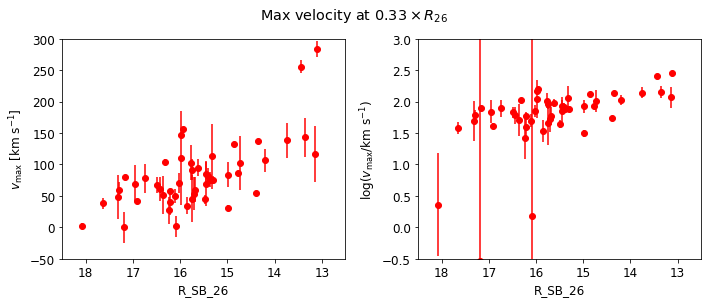

In [6]:
rmag = np.asarray(rmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='R_SB_26',
       xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='R_SB_26',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

## Cuts on inclination angle and morphology

In [7]:
rmag_clean = []
vmax_clean = []
dvmax_clean = []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))
inComa_sga_table['cosi'] = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))

i = 0

for sga_id in np.unique(inComa_sga_table['SGA_ID']):
    galaxy_list = inComa_sga_table[inComa_sga_table['SGA_ID'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    targetid = sga_galaxy['TARGETID'][0]
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    idx, sep2d, sep3d = match_coordinates_sky(offcenter, center)
    morphtype = sga_galaxy['MORPHTYPE'][0]
    cosi = sga_galaxy['cosi'][0]
    r26 = 0.5 * float(sga_galaxy['D26'])
    sep_r26 = sep2d.to_value('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        continue
        
    i += 1
    print(i, sga_id, cosi)
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    sep_r26 = np.insert(sep_r26, 0, 0.)
    dv = np.insert(dv, 0, 0.)
    dv_err = np.insert(dv_err, 0, 3e5*zc_err)
    
    # Extract the 0.33xR26 points.
    is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
    v033 = np.mean(dv[is_033_r26]) / (1 - cosi**2)
    dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / (1 - cosi**2)
    
    rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
    vmax_clean.append(v033)
    dvmax_clean.append(dv033)

<ipython-input-7-4cd9151c0719>:7: RuntimeWarning: invalid value encountered in sqrt
  inComa_sga_table['cosi'] = np.sqrt((inComa_sga_table['BA']**2 - q0**2)/(1 - q0**2))


1 25532 0.5290931
2 30149 0.38846168
3 122260 0.44236583
4 202666 0.42928275
5 291879 0.2719168
6 364929 0.1690408
7 365429 0.56522965
8 378842 0.61736906
9 465951 0.59115505
10 479267 0.2823332
11 566771 0.1457485
12 645151 0.015211286
13 747077 0.22167145
14 748600 0.27829042
15 759003 0.22121634
16 819754 0.6686077
17 972260 0.11649524
18 995924 0.51245797
19 1050173 0.6856911
20 1124033 0.5048053
21 1167691 0.36561796
22 1352019 0.21388021
23 1356626 0.67075986
24 1364394 0.38605773
25 1367749 0.54512936
26 1387991 0.24845725
27 1393079 0.4521807


In [8]:
def l1norm(pars, x, y, dy):
    '''
    Linear fit that uses the l1-norm (robust against outliers).
    '''
    a, b = pars
    return np.sum(np.abs((y - a - b*x)/dy))

def fit_tfr(r, logv, dlogv):
    fmin = 1e99
    a, b = 2.5, -0.5
    
    # Try a large number of random seeds to ensure a decent fit.
    for i in range(100):
        _a, _b = np.random.uniform(0,10), np.random.uniform(-1,0)
        
        res = minimize(l1norm, [_a, _b], args=(r, logv, dlogv),
                       method='L-BFGS-B', bounds=[[0,5], [-1,0]])
        
        if res.fun < fmin and res.status:
            print('Successful fit')
            fmin = res.fun
            a, b = res.x
    
    print(res)
    return a, b

      fun: nan
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([ 0.84988304, -0.92647201])
2.5 -0.5
      fun: nan
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([ 2.59658375, -0.15808531])
2.5 -0.5


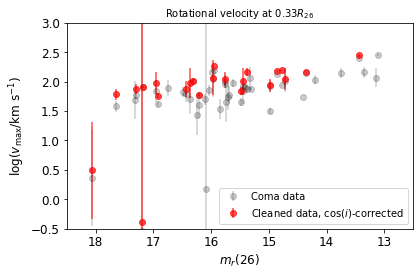

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.2,
            label='Coma data')

a, b = fit_tfr(rmag[isrmeas], log10vmax[isrmeas], dlog10vmax[isrmeas])
print(a, b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'k--', alpha=0.2)

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b = fit_tfr(rmag_clean[isrmeas_clean], 
               log10vmax_clean[isrmeas_clean], 
               dlog10vmax_clean[isrmeas_clean])
print(a, b)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)

ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))